## Mount Google Drive

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Get scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [3]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [4]:
from getData import getDataframe
import pandas as pd

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test'], include_unknown=True) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=True) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 3081


## Install tf 2.0 and python speech features

In [5]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 83kB/s 
     |████████████████████████████████| 501kB 48.4MB/s 
     |████████████████████████████████| 3.1MB 38.6MB/s 


In [28]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


In [6]:
!pip install -q python_speech_features

## Data Generators



In [0]:
from trainingUtils import _logMelFilterbank, _loadWavs
import numpy as np
import os

def _normalize(data):
    """
    Normalize feature vectors
    """
    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    return (data - mean) / (sd+1e-08)


def _parse_fn(filename, label, nfilt=40, scale=False):
    """
    Function used to compute filterbanks from file name.
    Returns (image, label)
    """
    wave = _loadWavs(filename.numpy())
    fbank = _logMelFilterbank(wave, nfilt)
    if scale:
        fbank = _normalize(fbank)
    return fbank, np.asarray(label).astype(np.int32)

def getDataset(df, batch_size, cache_file=None, shuffle=True, nfilt=40, scale=False):
    """
    Return a tf.data.Dataset containg filterbanks, labels
    """
    data = tf.data.Dataset.from_tensor_slices(
        (df['files'].tolist(), df['labels'].tolist())
    )

    data = data.map(
        lambda filename, label: tuple(
            tf.py_function(
                _parse_fn,
                inp=[filename, label, nfilt, scale],
                Tout=[tf.float32, tf.int32]
                )
        ),
        num_parallel_calls=os.cpu_count()
    )

    if cache_file:
        data = data.cache(cache_file)

    if shuffle:
        data = data.shuffle(buffer_size=df.shape[0])

    data = data.batch(batch_size).prefetch(buffer_size=1)

    steps = df.shape[0] // batch_size

    return data, steps

In [0]:
BATCH_SIZE = 32
# Reduced trainign dataset by using a numer <60k
NUM_EXAMPLES = 100000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    scale=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    scale=True
)

## Model

![InceptionBlock](https://i.stack.imgur.com/vGIfJ.png)

In [59]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Reshape, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

def inceptionModule(x_input, n):
    # Conv 1x1
    conv_1x1 = Conv2D(n, (1,1), padding='same', activation='relu')(x_input)
    
    # Conv 3x3
    conv_3x3 = Conv2D(n, (1,1), padding='same', activation='relu')(x_input)
    conv_3x3 = Conv2D(n, (3,3), padding='same', activation='relu')(conv_3x3)
    
    # Conv 5x5
    conv_5x5 = Conv2D(n, (1,1), padding='same', activation='relu')(x_input)
    conv_5x5 = Conv2D(n, (3,3), padding='same', activation='relu')(conv_5x5)
    
    # pool + proj
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x_input)
    pool = Conv2D(n, (1,1), padding='same', activation='relu')(pool)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool], axis=3)
    
    return output

def Inception(input_shape=(99,40)):
    
    input_layer = Input(shape=(99, 40))
    
    reshape_layer = Reshape(input_shape=input_shape, target_shape=(99, 40, 1))(input_layer)
      
    x = Conv2D(64, (5,5), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = MaxPooling2D((2,2), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    
    x = inceptionModule(x, 32)
    x = inceptionModule(x, 64)
    x = MaxPooling2D((3,2), padding='same', strides=(1, 1))(x)
    
    x = inceptionModule(x, 64)
    x = inceptionModule(x, 128)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.4)(x)
    
    x = Dense(256, activation='relu')(x)
    
    x = Dense(30, activation='softmax')(x)
    
    model = Model(input_layer, x)
    return model

model = Inception()
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 99, 40)]     0                                            
__________________________________________________________________________________________________
reshape_22 (Reshape)            (None, 99, 40, 1)    0           input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_448 (Conv2D)             (None, 50, 20, 64)   1664        reshape_22[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_133 (MaxPooling2D (None, 50, 20, 64)   0           conv2d_448[0][0]                 
___________________________________________________________________________________________

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])

In [61]:
EPOCHS = 50

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    "inception.h5",
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

Epoch 1/50
1596/1596 [==============================] - 109s 68ms/step - loss: 1.9730 - sparse_categorical_accuracy: 0.4063 - val_loss: 0.7333 - val_sparse_categorical_accuracy: 0.7664
Epoch 2/50
1596/1596 [==============================] - 105s 66ms/step - loss: 0.5645 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.4973 - val_sparse_categorical_accuracy: 0.8539
Epoch 3/50
1596/1596 [==============================] - 104s 65ms/step - loss: 0.3867 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.3885 - val_sparse_categorical_accuracy: 0.8796
Epoch 4/50
1596/1596 [==============================] - 104s 65ms/step - loss: 0.3063 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.3456 - val_sparse_categorical_accuracy: 0.8920
Epoch 5/50
1596/1596 [==============================] - 104s 65ms/step - loss: 0.2677 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.3319 - val_sparse_categorical_accuracy: 0.8965
Epoch 6/50
1596/1596 [==============================] - 104s 65ms/step - lo

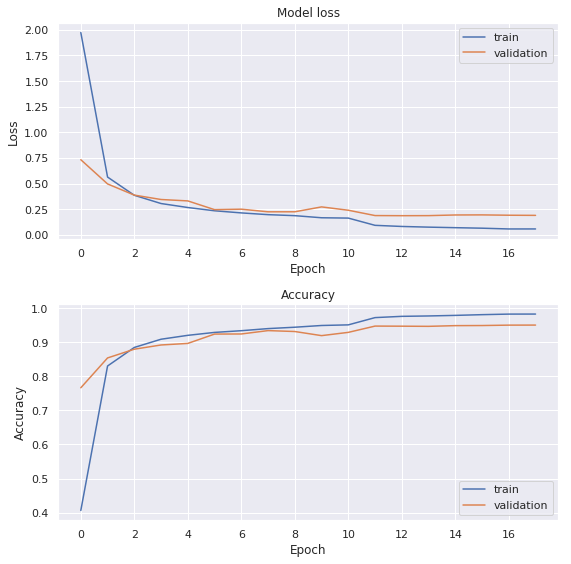

In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

## SGD

In [66]:
model_sgd = Inception()

epochs = 50
initial_lrate = 0.01

import math
def decay(epoch):
    initial_lrate = 0.01
    drop = 0.9
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

model_sgd.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(lr=initial_lrate, momentum=0.9, nesterov=False),
              metrics=["sparse_categorical_accuracy"])

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Reduce LR on Plateau
#reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
lr_sc = tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    "inception.h5",
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

history = model_sgd.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, lr_sc, modelCheckpoint])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/50
1596/1596 [==============================] - 107s 67ms/step - loss: 2.8351 - sparse_categorical_accuracy: 0.1705 - val_loss: 1.8399 - val_sparse_categorical_accuracy: 0.4344

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/50
1596/1596 [==============================] - 103s 65ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.6343 - val_loss: 0.8053 - val_sparse_categorical_accuracy: 0.7571

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009000000000000001.
Epoch 3/50
1596/1596 [==============================] - 103s 65ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.5200 - val_sparse_categorical_accuracy: 0.8421

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009000000000000001.
Epoch 4/50
1596/1596 [==============================] - 103s 64ms/step - loss: 0.4503 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.457

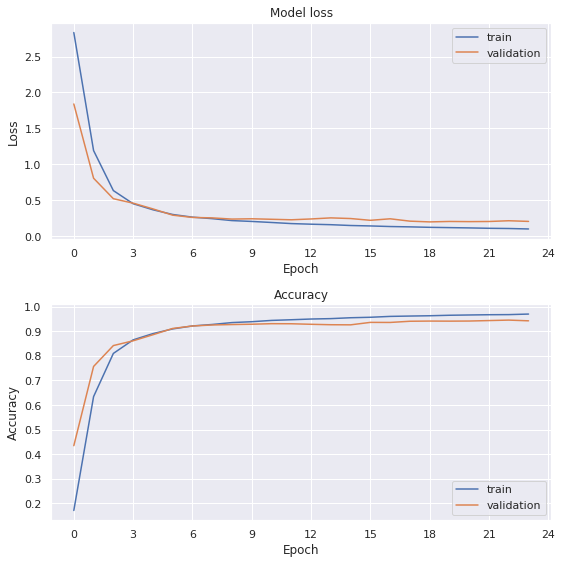

In [67]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

## Save to drive


In [64]:
import pickle

GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/inception/"

# Save model
model.save(GDRIVE_PATH + "inception95.h5")
print("Saved model to drive")

# Save history data
with open(GDRIVE_PATH + "train_history_inception95.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved model to drive
Saved training history to drive
